# Makine Öğrenmesiyle Elektrik Arızaların Tespiti

In [1]:
# gerekli kütüphanelerin import edilmesi
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
df = pd.read_csv('/home/ersel/Documents/GitHub/DataScience/DataSets/detections.csv') # veri seti

### Veri setinin incelenmesi ve Manipüle Edilmesi

In [3]:
df # verisetinin ön izlenmesi

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983
...,...,...,...,...,...,...,...,...,...,...
7856,0,0,0,0,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598
7857,0,0,0,0,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407
7858,0,0,0,0,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104
7859,0,0,0,0,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690


In [4]:
df.shape # (satır, sutun)

(7861, 10)

In [5]:
df.isnull().sum() # boş gözlemlerin sayısı

G     0
C     0
B     0
A     0
Ia    0
Ib    0
Ic    0
Va    0
Vb    0
Vc    0
dtype: int64

In [6]:
df.isnull().values.any() # verisetinde boş degerler var mı?

False

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7861 entries, 0 to 7860
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   G       7861 non-null   int64  
 1   C       7861 non-null   int64  
 2   B       7861 non-null   int64  
 3   A       7861 non-null   int64  
 4   Ia      7861 non-null   float64
 5   Ib      7861 non-null   float64
 6   Ic      7861 non-null   float64
 7   Va      7861 non-null   float64
 8   Vb      7861 non-null   float64
 9   Vc      7861 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 675.6 KB


### Verisetinin Görselleştirilmesi

<Figure size 1728x576 with 0 Axes>

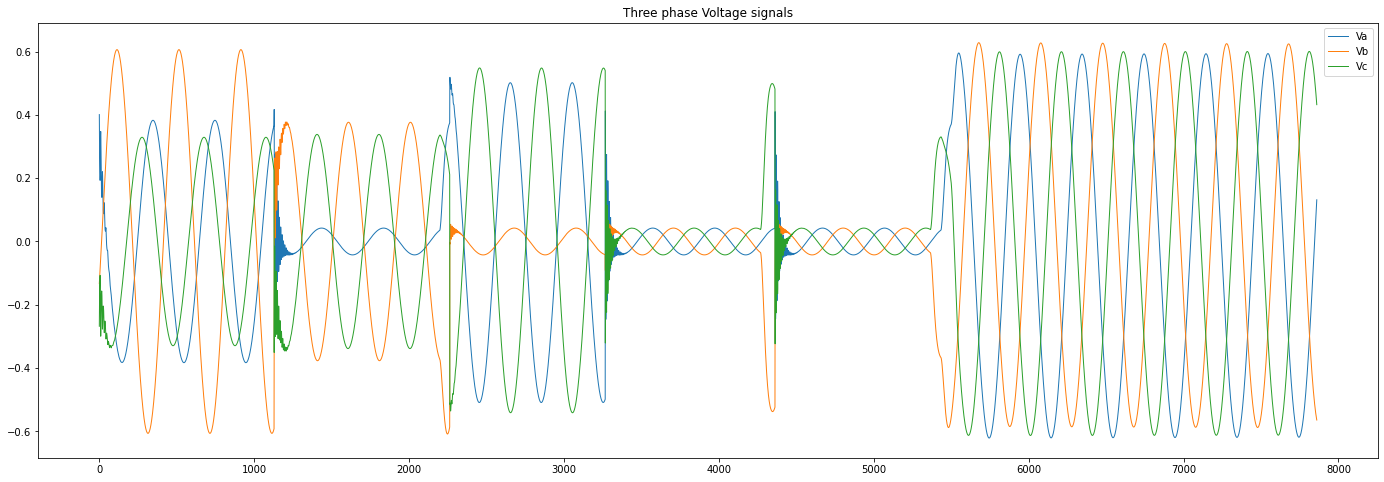

In [8]:
plt.figure(figsize=(24, 8))
plt.figure(figsize=(24, 8))
plt.plot(df.Va, label= 'Va', linewidth=1)
plt.plot(df.Vb, label= 'Vb', linewidth=1)
plt.plot(df.Vc, label= 'Vc', linewidth=1)
plt.title("Three phase Voltage signals")
plt.legend()
plt.show();

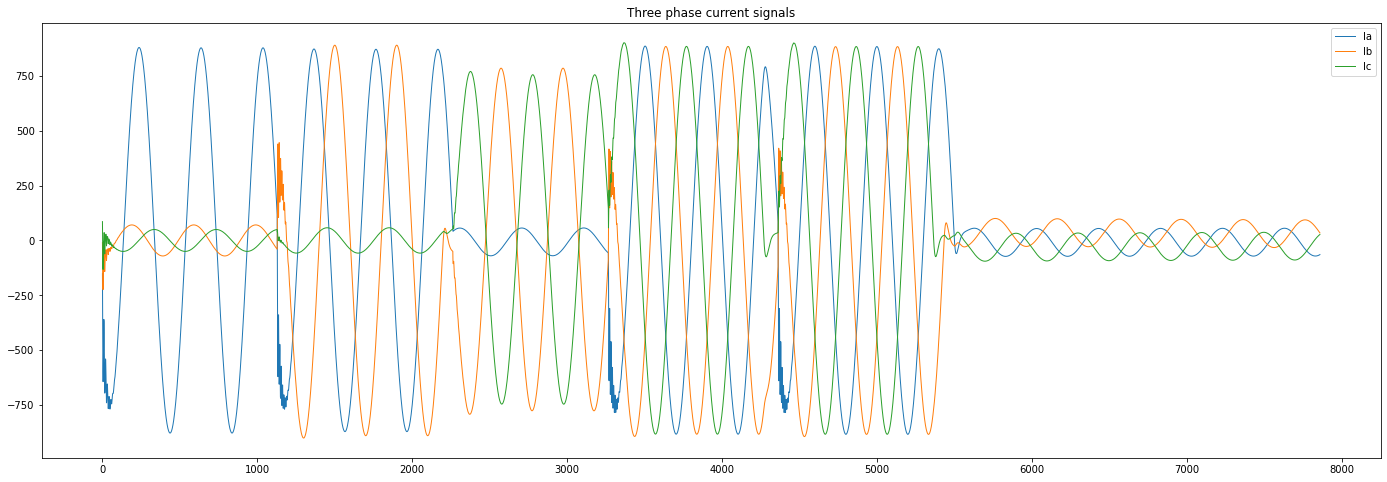

In [9]:
plt.figure(figsize=(24, 8))
plt.plot(df.Ia, label= 'Ia', linewidth=1)
plt.plot(df.Ib, label= 'Ib', linewidth=1)
plt.plot(df.Ic, label= 'Ic', linewidth=1)
plt.title("Three phase current signals")
plt.legend()
plt.show()

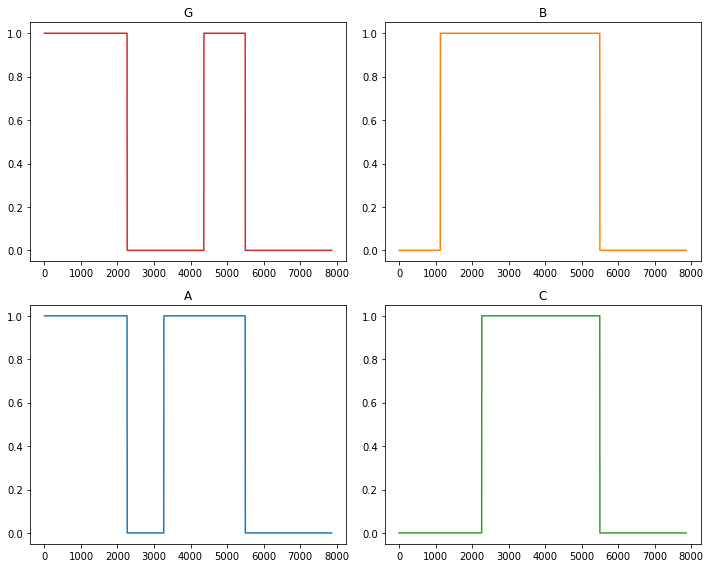

In [10]:
f, axs = plt.subplots(2,2,figsize=(10,8))
axs[0, 0].plot(df.G, 'tab:red'); axs[0, 0].set_title("G")
axs[1, 0].plot(df.A, 'tab:blue' ); axs[1, 0].set_title("A")
axs[0, 1].plot(df.B, 'tab:orange'); axs[0, 1].set_title("B")
axs[1, 1].plot(df.C, 'tab:green'); axs[1, 1].set_title("C")
f.tight_layout()

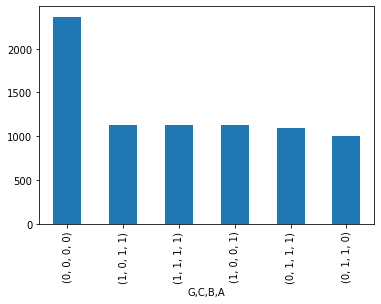

In [11]:
df.iloc[:, 0:4].value_counts().plot(kind='bar');

* [0 0 0 0] - No Fault (hata yok)
* [1 0 0 1] - LG fault (Between Phase A and Gnd)
* [0 0 1 1] - LL fault (Between Phase A and Phase B)
* [1 0 1 1] - LLG Fault (Between Phases A,B and ground)
* [0 1 1 1] - LLL Fault(Between all three phases)
* [1 1 1 1] - LLLG fault( Three phase symmetrical fault)

In [12]:
df['fault_types'] = df['G'].astype('str') + df['C'].astype('str') + df['B'].astype('str') + df['A'].astype('str')
df.head()

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,fault_types
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,1001
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,1001
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,1001
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,1001
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,1001


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7861 entries, 0 to 7860
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   G            7861 non-null   int64  
 1   C            7861 non-null   int64  
 2   B            7861 non-null   int64  
 3   A            7861 non-null   int64  
 4   Ia           7861 non-null   float64
 5   Ib           7861 non-null   float64
 6   Ic           7861 non-null   float64
 7   Va           7861 non-null   float64
 8   Vb           7861 non-null   float64
 9   Vc           7861 non-null   float64
 10  fault_types  7861 non-null   object 
dtypes: float64(6), int64(4), object(1)
memory usage: 737.0+ KB


In [14]:
df.fault_types.value_counts()

0000    2365
1011    1134
1111    1133
1001    1129
0111    1096
0110    1004
Name: fault_types, dtype: int64

[G C B A]
[0 0 0 0] -> No fault 
[1 0 0 1] -> LG fault
[0 1 1 0] -> LL fault
[1 0 1 1] -> LLG Fault
[0 1 1 1] -> LLL Fault
[1 1 1 1] -> LLLG fault



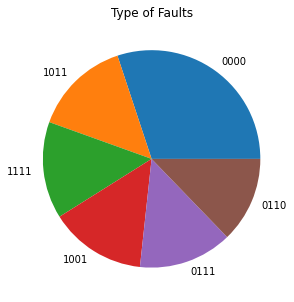

In [15]:
print("[G C B A]\n[0 0 0 0] -> No fault \n[1 0 0 1] -> LG fault\n[0 1 1 0] -> LL fault\n[1 0 1 1] -> LLG Fault\n[0 1 1 1] -> LLL Fault\n[1 1 1 1] -> LLLG fault\n")
plt.figure(figsize=(8,5))
df.fault_types.value_counts().plot.pie()
plt.title("Type of Faults")
plt.ylabel("")
plt.show()

In [16]:
NF = df[df['fault_types']=='0000']
LG = df[df['fault_types']=='1001'] 
LL = df[df['fault_types']=='0110'] 
LLG = df[df['fault_types']=='1011'] 
LLL = df[df['fault_types']=='0111'] 
LLLG = df[df['fault_types']=='1111']

For No Fault


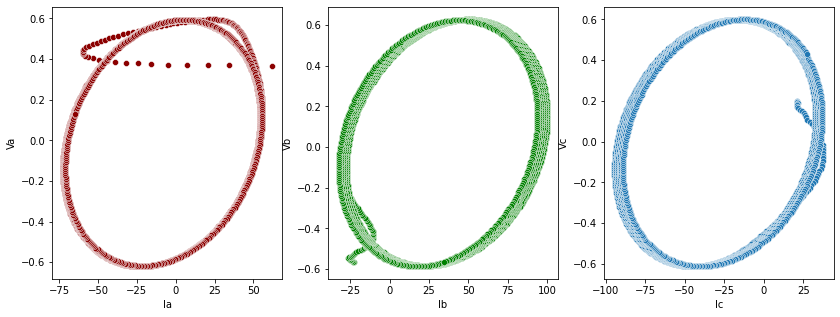

In [17]:
print("For No Fault")
plt.subplots(1,3,figsize=(14,5))
plt.subplot(131)
sns.scatterplot(x=NF['Ia'],y=NF['Va'],color='darkred')

plt.subplot(132)
sns.scatterplot(x=NF['Ib'],y=NF['Vb'],color='green')

plt.subplot(133)
sns.scatterplot(x=NF['Ic'],y=NF['Vc'])

plt.show()

For Line Ground Fault


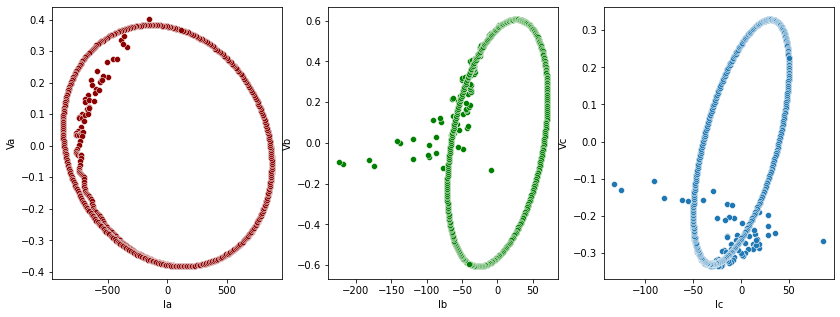

In [18]:
print("For Line Ground Fault")
plt.subplots(1,3,figsize=(14,5))
plt.subplot(131)
sns.scatterplot(x=LG['Ia'],y=LG['Va'],color='darkred')

plt.subplot(132)
sns.scatterplot(x=LG['Ib'],y=LG['Vb'],color='green')

plt.subplot(133)
sns.scatterplot(x=LG['Ic'],y=LG['Vc'])

plt.show()

For Line to Line Fault


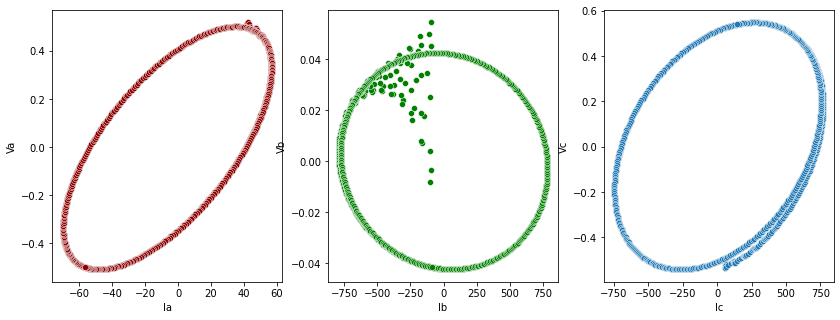

In [19]:
print("For Line to Line Fault")
plt.subplots(1,3,figsize=(14,5))
plt.subplot(131)
sns.scatterplot(x=LL['Ia'],y=LL['Va'],color='darkred')

plt.subplot(132)
sns.scatterplot(x=LL['Ib'],y=LL['Vb'],color='green')

plt.subplot(133)
sns.scatterplot(x=LL['Ic'],y=LL['Vc'])

plt.show()

For Line Line Ground Fault


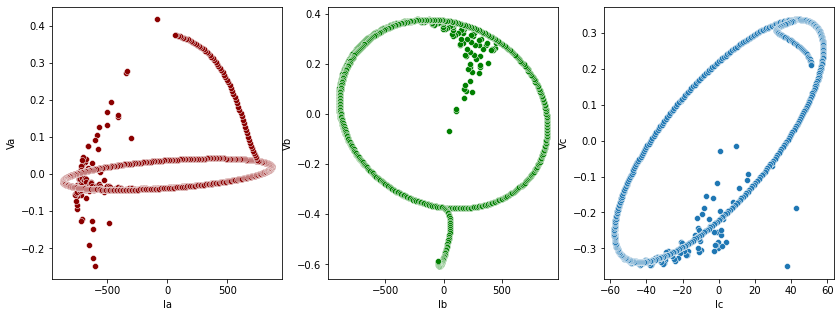

In [20]:
print("For Line Line Ground Fault")
plt.subplots(1,3,figsize=(14,5))
plt.subplot(131)
sns.scatterplot(x=LLG['Ia'],y=LLG['Va'],color='darkred')

plt.subplot(132)
sns.scatterplot(x=LLG['Ib'],y=LLG['Vb'],color='green')

plt.subplot(133)
sns.scatterplot(x=LLG['Ic'],y=LLG['Vc'])

plt.show()

For Line Line Line Fault


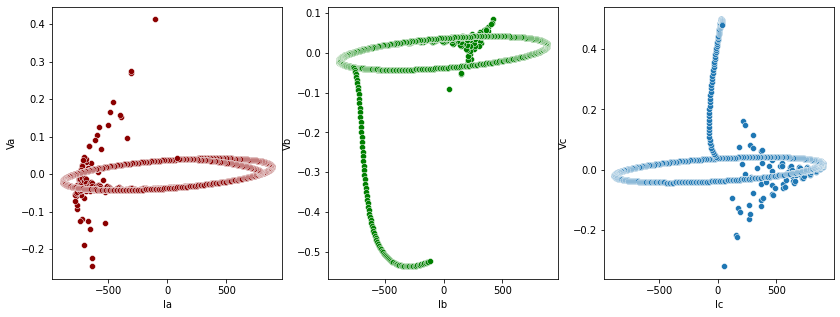

In [21]:
print("For Line Line Line Fault")
plt.subplots(1,3,figsize=(14,5))
plt.subplot(131)
sns.scatterplot(x=LLL['Ia'],y=LLL['Va'],color='darkred')

plt.subplot(132)
sns.scatterplot(x=LLL['Ib'],y=LLL['Vb'],color='green')

plt.subplot(133)
sns.scatterplot(x=LLL['Ic'],y=LLL['Vc'])

plt.show()

### Model Kurulumları

In [22]:
df.head()

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,fault_types
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,1001
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,1001
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,1001
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,1001
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,1001


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7861 entries, 0 to 7860
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   G            7861 non-null   int64  
 1   C            7861 non-null   int64  
 2   B            7861 non-null   int64  
 3   A            7861 non-null   int64  
 4   Ia           7861 non-null   float64
 5   Ib           7861 non-null   float64
 6   Ic           7861 non-null   float64
 7   Va           7861 non-null   float64
 8   Vb           7861 non-null   float64
 9   Vc           7861 non-null   float64
 10  fault_types  7861 non-null   object 
dtypes: float64(6), int64(4), object(1)
memory usage: 737.0+ KB


In [24]:
X = df.drop(columns=['fault_types'],axis=1).values # bagımsız degiskenler
y = df['fault_types'] # bagımlı degiskenler

In [25]:
# egitim ve test seti ayırma islemi
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state = 42)

### KNN ile Modelleme

In [26]:
# optimum k degerinin bulunması
knn = KNeighborsClassifier().fit(X_train, y_train)
knn_params = {'n_neighbors': np.arange(1, 50)}
knn_cv = GridSearchCV(knn, knn_params, cv = 10).fit(X_train, y_train)
knn_cv

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [27]:
knn_cv.best_params_ # optimum k degeri

{'n_neighbors': 1}

In [28]:
# optimum k degeriyle model kurulumu
knn_model = KNeighborsClassifier(n_neighbors = knn_cv.best_params_['n_neighbors'])
knn_model = knn_model.fit(X_train, y_train)
knn_model

KNeighborsClassifier(n_neighbors=1)

In [29]:
y_pred = knn_model.predict(X_test)
score = accuracy_score(y_test, y_pred)
score # model dogruluk skoru

0.896236012207528

In [30]:
# caprazlama ile dogrulanmıs skor
dogSkor_knn = cross_val_score(knn_model, X_train, y_train, cv = 10, scoring = 'accuracy').mean()
dogSkor_knn

0.8692141233345803

In [31]:
print(classification_report(y_test, y_pred)) # sınıflandırma raporu

              precision    recall  f1-score   support

        0000       1.00      1.00      1.00       601
        0110       1.00      0.99      1.00       247
        0111       0.61      0.66      0.64       249
        1001       0.97      0.99      0.98       302
        1011       0.98      0.98      0.98       291
        1111       0.67      0.61      0.64       276

    accuracy                           0.90      1966
   macro avg       0.87      0.87      0.87      1966
weighted avg       0.90      0.90      0.90      1966



In [32]:
print(f'KNN algoritmasıyla elde edilen modelin basarı skoru: {dogSkor_knn}')

KNN algoritmasıyla elde edilen modelin basarı skoru: 0.8692141233345803


In [33]:
# tahminleme

In [34]:
test = pd.DataFrame(X_test, columns = df.columns[:-1])

In [35]:
tahmin_test = pd.DataFrame(knn_model.predict(X_test), columns = ['tahmin_fault_types'])

In [36]:
a = pd.concat([test, tahmin_test], axis = 1)

In [37]:
a[a.tahmin_fault_types == '0000'][:40]

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,tahmin_fault_types
0,0.0,0.0,0.0,0.0,-41.381476,2.186933,36.108541,0.423758,-0.562913,0.139154,0000
4,0.0,0.0,0.0,0.0,55.236315,-3.679429,-52.902664,0.214181,0.392834,-0.607015,0000
10,0.0,0.0,0.0,0.0,-71.236699,66.537400,1.709918,-0.179366,-0.402545,0.581910,0000
12,0.0,0.0,0.0,0.0,54.121303,-8.845342,-46.229554,0.274138,0.338009,-0.612146,0000
14,0.0,0.0,0.0,0.0,23.124916,64.980042,-91.250244,-0.463043,0.596030,-0.132987,0000
17,0.0,0.0,0.0,0.0,-37.617238,94.971179,-60.362054,-0.596506,0.170116,0.426389,0000
19,0.0,0.0,0.0,0.0,-34.678501,97.232545,-65.803800,-0.606558,0.208155,0.398402,0000
25,0.0,0.0,0.0,0.0,24.809698,-27.260464,-0.988444,0.554757,-0.083584,-0.471173,0000
26,0.0,0.0,0.0,0.0,5.556191,79.618441,-88.314181,-0.562521,0.515671,0.046850,0000
33,0.0,0.0,0.0,0.0,-56.476240,20.961782,32.422519,0.272586,-0.586394,0.313808,0000


### SVM ile Modelleme

In [38]:
# optimum C parametresinin belirlenmesi
svc = SVC().fit(X_train, y_train)
svc_params = {'C': np.arange(1, 10)}
svc_cv = GridSearchCV(svc, svc_params, cv = 10).fit(X_train, y_train)
svc_cv

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [39]:
svc_cv.best_params_ # optimum C degeri

{'C': 9}

In [40]:
# optimum c degeriyle model kurulumu
svc_model = SVC(C = svc_cv.best_params_['C'], kernel = 'rbf')
svc_model = svc_model.fit(X_train, y_train)
svc_model

SVC(C=9)

In [41]:
y_pred = svc_model.predict(X_test)
score = accuracy_score(y_test, y_pred)
score # model dogruluk skoru

0.7945066124109867

In [42]:
# caprazlama ile dogrulanmıs skor
dogSkor_svc = cross_val_score(svc_model, X_train, y_train, cv = 10, scoring = 'accuracy').mean()
dogSkor_svc

0.7759140744151247

In [43]:
print(classification_report(y_test, y_pred)) # sınıflandırma raporu

              precision    recall  f1-score   support

        0000       0.93      1.00      0.96       601
        0110       0.84      0.93      0.88       247
        0111       0.49      0.60      0.54       249
        1001       0.85      0.91      0.88       302
        1011       0.85      0.86      0.86       291
        1111       0.47      0.20      0.28       276

    accuracy                           0.79      1966
   macro avg       0.74      0.75      0.73      1966
weighted avg       0.77      0.79      0.77      1966



In [44]:
print(f'SVC algoritmasıyla elde edilen modelin basarı skoru: {dogSkor_svc}')

SVC algoritmasıyla elde edilen modelin basarı skoru: 0.7759140744151247


In [45]:
print(f'KNN algoritmasıyla elde edilen modelin basarı skoru: {dogSkor_knn}')

KNN algoritmasıyla elde edilen modelin basarı skoru: 0.8692141233345803


In [46]:
# tahminleme

In [47]:
test = pd.DataFrame(X_test, columns = df.columns[:-1])

In [48]:
tahmin_test = pd.DataFrame(svc_model.predict(X_test), columns = ['tahmin_fault_types'])

In [49]:
a = pd.concat([test, tahmin_test], axis = 1)

In [50]:
a[a.tahmin_fault_types == '0000'][:40]

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,tahmin_fault_types
0,0.0,0.0,0.0,0.0,-41.381476,2.186933,36.108541,0.423758,-0.562913,0.139154,0000
4,0.0,0.0,0.0,0.0,55.236315,-3.679429,-52.902664,0.214181,0.392834,-0.607015,0000
7,0.0,1.0,1.0,0.0,50.401311,-50.711921,2.917205,0.463390,0.042370,-0.505759,0000
10,0.0,0.0,0.0,0.0,-71.236699,66.537400,1.709918,-0.179366,-0.402545,0.581910,0000
12,0.0,0.0,0.0,0.0,54.121303,-8.845342,-46.229554,0.274138,0.338009,-0.612146,0000
14,0.0,0.0,0.0,0.0,23.124916,64.980042,-91.250244,-0.463043,0.596030,-0.132987,0000
17,0.0,0.0,0.0,0.0,-37.617238,94.971179,-60.362054,-0.596506,0.170116,0.426389,0000
19,0.0,0.0,0.0,0.0,-34.678501,97.232545,-65.803800,-0.606558,0.208155,0.398402,0000
25,0.0,0.0,0.0,0.0,24.809698,-27.260464,-0.988444,0.554757,-0.083584,-0.471173,0000
26,0.0,0.0,0.0,0.0,5.556191,79.618441,-88.314181,-0.562521,0.515671,0.046850,0000


## SONUÇ

* Bu verisetinde, KNN ve SVM olmak üzere iki farklı makine öğrenmesi algoritmaları kullanıldı. 
* Bu algoritmalar arasında en iyi çalışan model 0.869 başarı oranıyla KNN oldu.
* Farklı makine algoritmalarıyla bu başarı skoru yükseltilebilir.
* Uygulanan model algoritması, sinyal ölçme cihazlarına entegre edilerek hataların önceden tespit ederek olası büyük felaketleri önleyebilir.